In [1]:
# Necessary Librabries
import pandas as pd
import numpy as np
import re
import os
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

import nltk
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud

In [2]:
import contractions
import emoji
import string 
import re

In [3]:
gpus = tf.config.list_physical_devices('GPU')

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

In [6]:
twitter_data = pd.read_csv("dataset/text_classification.csv", index_col=[0])

In [7]:
twitter_data

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [8]:
twitter_data.reset_index(inplace=True)
twitter_data.drop("index",inplace=True,axis=1)
twitter_data

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,6,0,6,0,1,youu got wild bitches tellin you lies


In [9]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


## Dataset cleaning

In [10]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


In [11]:
# Drop any rows that has a null value
clean_twitter_data = twitter_data.dropna(how='any',axis=0) 
clean_twitter_data

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,6,0,6,0,1,youu got wild bitches tellin you lies


In [12]:
# Mapping the class to its respective labels
# Hate Speech = 0
# Offensive = 1
# Neither = 2

mapping = {0: 'hate_speech', 1: 'offensive_language', 2: 'neither'}
clean_twitter_data['class'] = clean_twitter_data['class'].map(mapping)
clean_twitter_data

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,neither,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,offensive_language,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,offensive_language,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,offensive_language,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,offensive_language,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
24778,3,0,2,1,offensive_language,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,3,0,1,2,neither,"you've gone and broke the wrong heart baby, an..."
24780,3,0,3,0,offensive_language,young buck wanna eat!!.. dat nigguh like I ain...
24781,6,0,6,0,offensive_language,youu got wild bitches tellin you lies


In [13]:
# Look for incorrect labelling of the classes where the class does not have the majority "vote"

incorrect_label_df = pd.DataFrame()
for index, row in clean_twitter_data.iterrows():
    max_count = max(row['hate_speech'], row['offensive_language'], row['neither'])
    if row['class'] == 'hate_speech' and row['hate_speech'] != max_count:
        incorrect_label_df = incorrect_label_df.append(row)
    elif row['class'] == 'offensive_language' and row['offensive_language'] != max_count:
        incorrect_label_df = incorrect_label_df.append(row)
    elif row['class'] == 'neither' and row['neither'] != max_count:
        incorrect_label_df = incorrect_label_df.append(row)

print("Rows where the 'class' column has an incorrect label:")
print(incorrect_label_df)

Rows where the 'class' column has an incorrect label:
Empty DataFrame
Columns: []
Index: []


In [14]:
# Check if there are any rows that two or more labels have the majority 

check_highest_df = pd.DataFrame()
for index, row in clean_twitter_data.iterrows():
    max_count = max(row['hate_speech'], row['offensive_language'], row['neither'])
    labels_with_max_count = [label for label in ['hate_speech', 'offensive_language', 'neither'] if row[label] == max_count]
    if len(labels_with_max_count) > 1:
        check_highest_df = check_highest_df.append(row)

print("Rows where two or more classes have the highest count:")
print(check_highest_df)

Rows where two or more classes have the highest count:
Empty DataFrame
Columns: []
Index: []


In [15]:
# First cleaning 
# Remove `RT` for retweet
def remove_RT(text):
    rt_pattern = re.compile(r'\bRT\b', re.IGNORECASE)
    text = rt_pattern.sub('', text)
    return text

# Remove digits in tweets 
def remove_digits(text):
    
    text = re.sub(r'\d+', '', text)
    return text

In [16]:
clean_twitter_data["tweet"] = clean_twitter_data["tweet"].apply(remove_RT)
clean_twitter_data["tweet"] = clean_twitter_data["tweet"].apply(remove_digits)
clean_twitter_data

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,neither,!!! @mayasolovely: As a woman you shouldn't c...
1,3,0,3,0,offensive_language,!!!!! @mleew: boy dats cold...tyga dwn bad fo...
2,3,0,3,0,offensive_language,!!!!!!! @UrKindOfBrand Dawg!!!! @sbabylife: ...
3,3,0,2,1,offensive_language,!!!!!!!!! @C_G_Anderson: @viva_based she look...
4,6,0,6,0,offensive_language,!!!!!!!!!!!!! @ShenikaRoberts: The shit you h...
...,...,...,...,...,...,...
24778,3,0,2,1,offensive_language,you's a muthaf***in lie &#;@LifeAsKing: @_Pear...
24779,3,0,1,2,neither,"you've gone and broke the wrong heart baby, an..."
24780,3,0,3,0,offensive_language,young buck wanna eat!!.. dat nigguh like I ain...
24781,6,0,6,0,offensive_language,youu got wild bitches tellin you lies


# Data Exploration

In [17]:
for element in np.unique(clean_twitter_data['count']):
    print("Count of {} annotators in dataset: {}".format(element, clean_twitter_data['count'].value_counts()[element]))

Count of 3 annotators in dataset: 22807
Count of 4 annotators in dataset: 211
Count of 6 annotators in dataset: 1571
Count of 7 annotators in dataset: 27
Count of 9 annotators in dataset: 167


## Spread of the number of annotators per tweet

<AxesSubplot: xlabel='count', ylabel='count'>

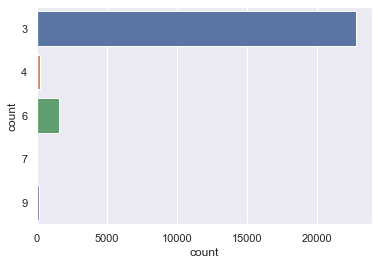

In [18]:
sb.countplot(y = "count", data = clean_twitter_data)

In [19]:
# Check the number of unique labels
print("Number of different labels: ", len(np.unique(clean_twitter_data["class"])))
num_classes = len(np.unique(clean_twitter_data["class"]))
# Identify the number of data per label
for element in np.unique(clean_twitter_data['class']):
    print("Number of {} in dataset: {}".format(element, clean_twitter_data['class'].value_counts()[element]))

Number of different labels:  3
Number of hate_speech in dataset: 1430
Number of neither in dataset: 4163
Number of offensive_language in dataset: 19190


## Explore the count of each class 

<AxesSubplot: xlabel='count', ylabel='class'>

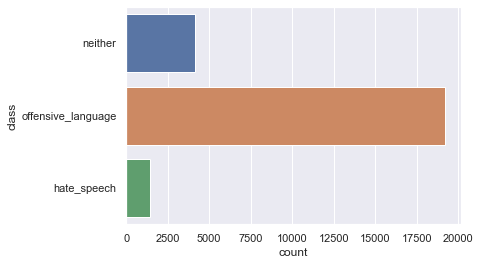

In [20]:
# Data Exploration
sb.countplot(y = "class", data = clean_twitter_data)

In [21]:
from collections import Counter
# Lets observe the top 10 Hashtag for each class
# extract hashtags and count frequency for each class
hashtags_by_class = {}
for label in clean_twitter_data['class'].unique():
    tweets = clean_twitter_data.loc[clean_twitter_data['class'] == label, 'tweet']
    hashtags = []
    for tweet in tweets:
        hashtags.extend(re.findall(r'#\w+', tweet))
    hashtags_by_class[label] = Counter(hashtags)


## Top 10 Hashtag per class

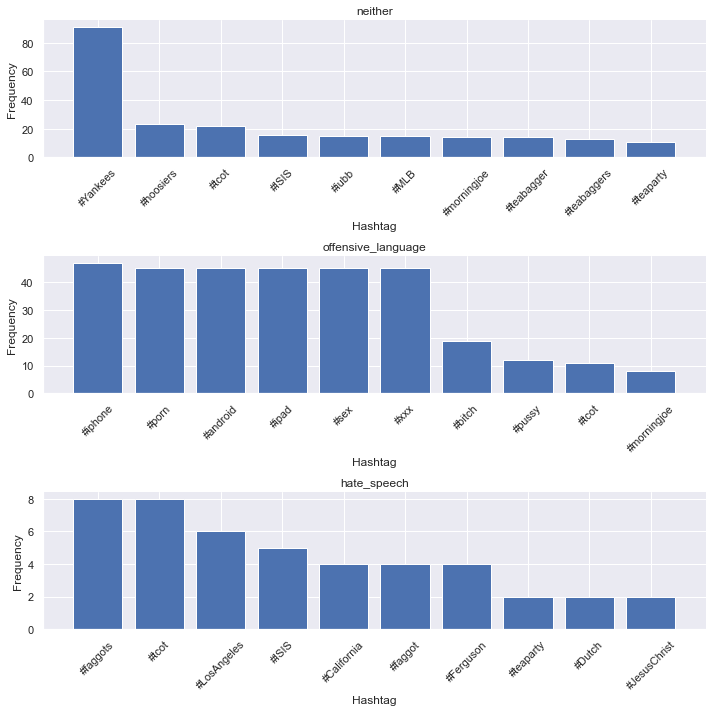

In [22]:
# create a plot for each class 
fig, axes = plt.subplots(nrows=len(hashtags_by_class), figsize=(10, 10))

for i, (label, counts) in enumerate(hashtags_by_class.items()):
    top_n = counts.most_common(10)
    tags = [tag for tag, count in top_n]
    values = [count for tag, count in top_n]
    ax = axes[i]
    ax.bar(tags, values)
    ax.set_title(label)
    ax.set_xlabel('Hashtag')
    ax.set_ylabel('Frequency')
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', labelrotation = 45)
    ax.spines['top'].set_visible(False)
fig.savefig('visualizations/Top_10_Most_Hashtags.jpg')
fig.tight_layout()
plt.show()

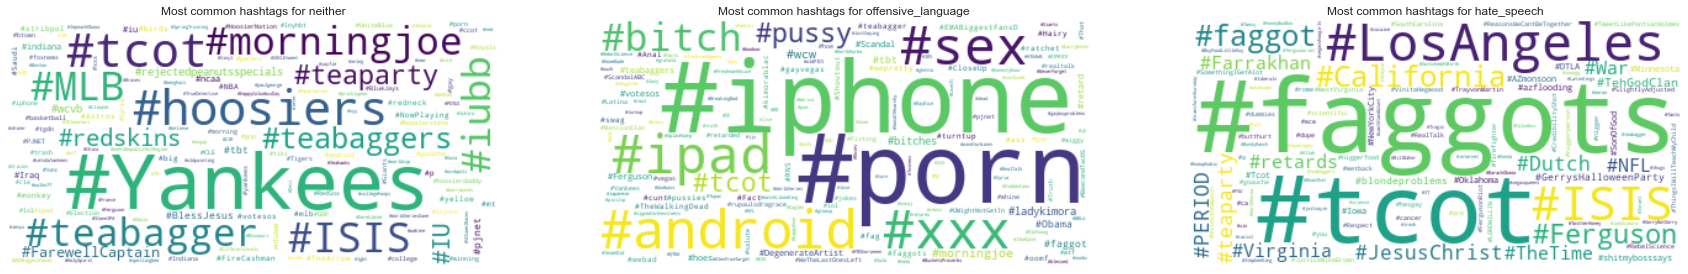

In [23]:
import matplotlib.pyplot as plt
fig, axes =plt.subplots(1,3, figsize=(30,30))
# Create a dictionary of hashtag frequencies
freqs = {}
for label, hashtags in hashtags_by_class.items():
    freqs[label] = {}
    for hashtag, count in hashtags.items():
        freqs[label][hashtag] = count
column = 0
# Generate a word cloud for each label
for label, freq_dict in freqs.items():
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(freq_dict)
    axes[column].imshow(wordcloud, interpolation='bilinear')
    axes[column].set_title(f'Most common hashtags for {label}')
    axes[column].axis('off')
    extent = axes[column].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('visualizations/'+label+'_hashtag_wordcloud.jpg', bbox_inches=extent.expanded(1.1, 1.2))
    column+=1

## Text Pre-processing functions

In [24]:
# Remove emojis 
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF" 
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

# Remove urls
def remove_urls(text):
    
    text = re.sub(r'http\S+', '', text)
    return text

# Remove any username @
def remove_username(text):
    
    text = re.sub('(@[^\s]+)', '', text)
    return text

# Remove any hashtags #
def remove_hashtags(text):
    
    text = re.sub(r'#(\S+)', r'\1', text)
    return text

# Remove Punctuations
def remove_punctuations(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

# Remove extra whitespaces
def remove_extra_whitespace(text):
    
    return " ".join(text.split())

# Removing stopwords removes low-level information from our text in order to give more focus to the important information
def remove_stopwords(text):
    
    stopwords_list = stopwords.words('english')
    words = text.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 1]
    return " ".join(clean_words)

# change to lower_case
def lower_case(text):
    
    return text.lower()

# change contraction words such sa I'm = I am, shouldn't = should not
def change_contractions(text):
    
    expanded_words = [contractions.fix(word) for word in text.split()]

    expanded_text = ' '.join(expanded_words)
    return expanded_text

def get_wordnet_pos(text):
    # Map POS tag to first character lemmatize() accepts
    tags = nltk.pos_tag(text)
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    tags = [tag_dict.get(tag[1][0],  wordnet.NOUN) for tag in tags]
    return tags

def lemmaSentence(text):
    lemmatizer = WordNetLemmatizer()
    lemma_text = ''
    tok_text = word_tokenize(text)
    tags = get_wordnet_pos(tok_text)
    for i in range(len(tok_text)):
        lemma_text = lemma_text + ' ' + lemmatizer.lemmatize(tok_text[i], tags[i])
    return lemma_text[1:] 


# Create Word Cloud Visualization of each individual labels
def get_wordcloud(text, color='viridis'):
  # Create a WordCloud object
  wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', colormap=color,collocations=False)
  # Generate a word cloud
  return wordcloud.generate(text)

In [25]:
# The main function to clean tweets
def clean_tweets(data):
    clean_tweets = data.copy()
    clean_tweets["tweet"] = clean_tweets["tweet"].astype(str)
    clean_tweets['clean_tweets'] = clean_tweets['tweet'].apply(remove_username)
    clean_tweets['clean_tweets'] = clean_tweets['clean_tweets'].apply(remove_punctuations)
    clean_tweets['clean_tweets'] = clean_tweets['clean_tweets'].apply(remove_extra_whitespace)
    clean_tweets['clean_tweets'] = clean_tweets['clean_tweets'].apply(remove_emojis)
    clean_tweets['clean_tweets'] = clean_tweets['clean_tweets'].apply(remove_hashtags)
    clean_tweets['clean_tweets'] = clean_tweets['clean_tweets'].apply(remove_urls)
    clean_tweets['clean_tweets'] = clean_tweets['clean_tweets'].apply(remove_stopwords)
    clean_tweets['clean_tweets'] = clean_tweets['clean_tweets'].apply(lower_case)
    clean_tweets['clean_tweets'] = clean_tweets['clean_tweets'].apply(change_contractions)
    clean_tweets['clean_tweets'] = clean_tweets['clean_tweets'].apply(lemmaSentence)
    return clean_tweets

In [26]:
# clean_twitter_data = clean_tweets(clean_twitter_data)
# clean_twitter_data.to_csv("dataset/clean_twitter_data.csv")

In [27]:
clean_twitter_data = pd.read_csv("dataset/clean_twitter_data.csv", index_col = [0],encoding="utf-8")
clean_twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  object
 5   tweet               24783 non-null  object
 6   clean_tweets        24781 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.5+ MB


In [28]:
# There are tweets where after pre-processing are just empty strings
clean_twitter_data.dropna(inplace=True)
clean_twitter_data.reset_index(inplace=True)

## Top 20 most used tokens in each class

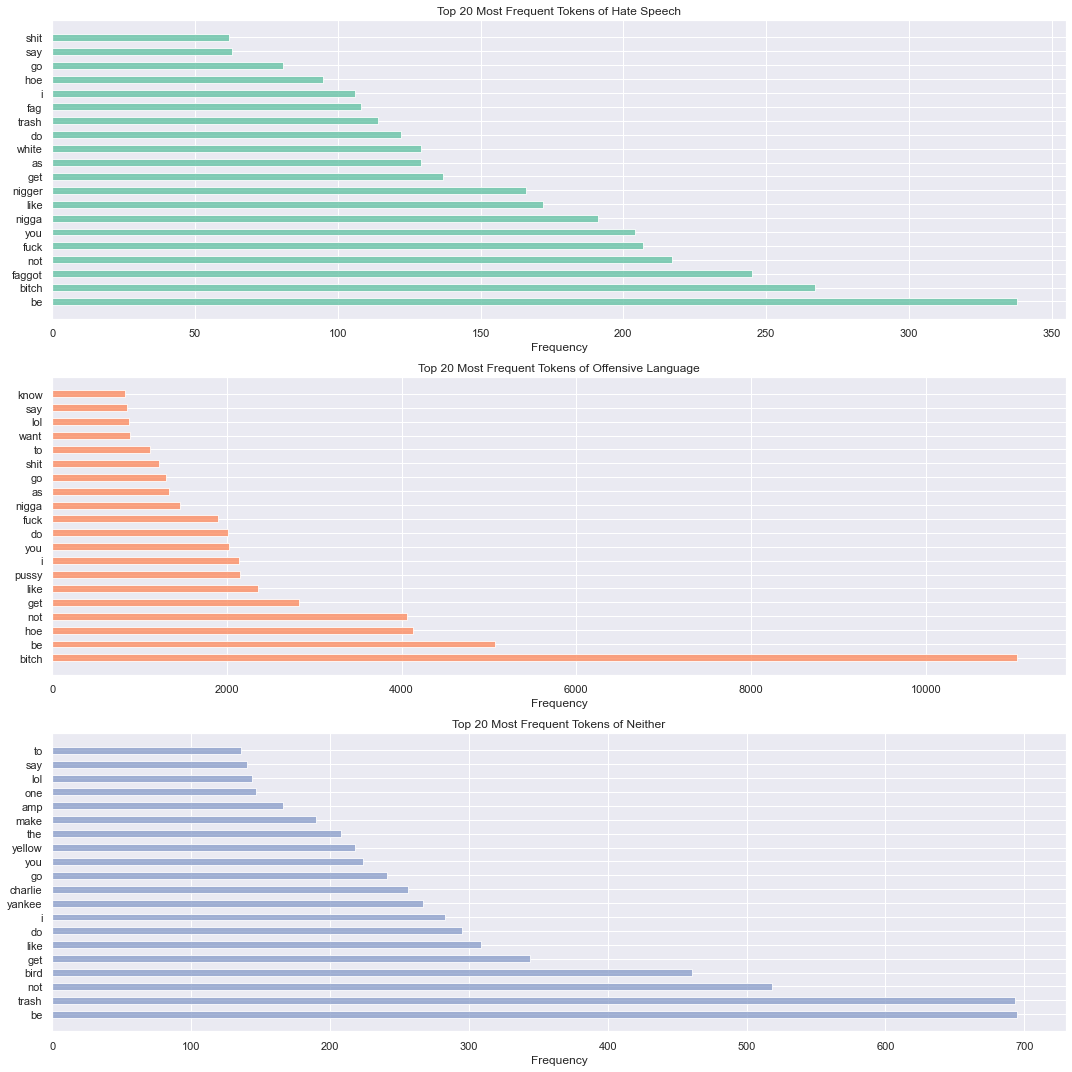

In [29]:
# Tokenize the tweets and count the frequency of each token for each label
hate_speech_tokens = []
offensive_tokens = []
neither_tokens = []

for i, row in clean_twitter_data.iterrows():
    tokens = word_tokenize(row['clean_tweets'])
    if row['class'] == 'hate_speech':
        hate_speech_tokens.extend(tokens)
    elif row['class'] == 'offensive_language':
        offensive_tokens.extend(tokens)
    elif row['class'] == 'neither':
        neither_tokens.extend(tokens)

hate_speech_counts = Counter(hate_speech_tokens)
offensive_counts = Counter(offensive_tokens)
neither_counts = Counter(neither_tokens)

# Get the top 10 most common tokens for each label
top_hate_speech_tokens = dict(hate_speech_counts.most_common(20))
top_offensive_tokens = dict(offensive_counts.most_common(20))
top_neither_tokens = dict(neither_counts.most_common(20))


# Create a separate bar plot for each label
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
bar_width = 0.5
opacity = 0.8
colors = ['#66c2a5', '#fc8d62', '#8da0cb']

axes[0].barh(range(len(top_hate_speech_tokens)), top_hate_speech_tokens.values(),
             bar_width, alpha=opacity, color=colors[0])
axes[0].set_yticks(range(len(top_hate_speech_tokens)))
axes[0].set_yticklabels(list(top_hate_speech_tokens.keys()))
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 20 Most Frequent Tokens of Hate Speech')

axes[1].barh(range(len(top_offensive_tokens)), top_offensive_tokens.values(),
             bar_width, alpha=opacity, color=colors[1])
axes[1].set_yticks(range(len(top_offensive_tokens)))
axes[1].set_yticklabels(list(top_offensive_tokens.keys()))
axes[1].set_xlabel('Frequency')
axes[1].set_title('Top 20 Most Frequent Tokens of Offensive Language')

axes[2].barh(range(len(top_neither_tokens)), top_neither_tokens.values(),
             bar_width, alpha=opacity, color=colors[2])
axes[2].set_yticks(range(len(top_neither_tokens)))
axes[2].set_yticklabels(list(top_neither_tokens.keys()))
axes[2].set_xlabel('Frequency')
axes[2].set_title('Top 20 Most Frequent Tokens of Neither')

fig.savefig('visualizations/Top_20_Most_Frequent Tokens.jpg')
plt.tight_layout()
plt.show()

## WordCloud visualisation of each class

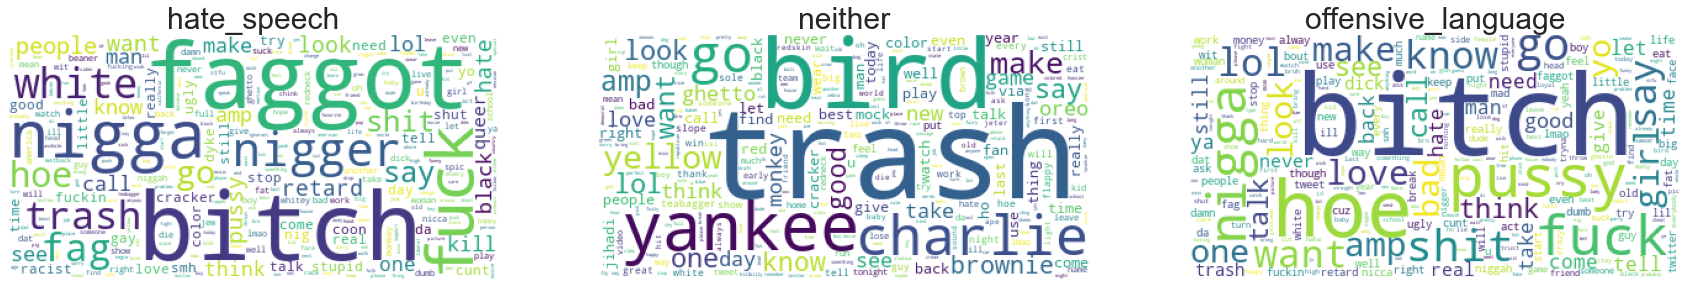

In [30]:
# WordCloud representation
fig, axes =plt.subplots(1,3, figsize=(30,30))
column  = 0
for label in np.unique(clean_twitter_data["class"]):
    axes[column].set_title(label, fontsize=30)
    text = ' '.join(clean_twitter_data["clean_tweets"][clean_twitter_data["class"]==label].values)
    axes[column].imshow(get_wordcloud(text))
    axes[column].axis('off')
    extent = axes[column].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('visualizations//'+label+'_wordcloud.jpg', bbox_inches=extent.expanded(1.1, 1.2))
    column+=1

## Overlap of the words betweens classes

In [31]:
# Tokenize the tweets for each class
offensive_words = set(word_tokenize(" ".join(clean_twitter_data['clean_tweets'][clean_twitter_data['class'] == 'offensive_language'])))
neither_words =  set(word_tokenize(" ".join(clean_twitter_data['clean_tweets'][clean_twitter_data['class'] == 'neither'])))
hate_speech_words = set(word_tokenize(" ".join(clean_twitter_data['clean_tweets'][clean_twitter_data['class'] == 'hate_speech'])))

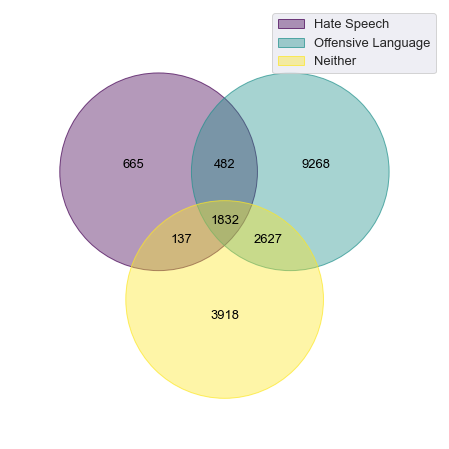

In [32]:
from venn import venn
# Venn Diagram that shows the overlap of words between the classes
venn({'Hate Speech': hate_speech_words, 'Offensive Language': offensive_words, 'Neither': neither_words})
plt.savefig("visualizations/Venn_Diagram.jpg")
plt.show()

# Lets look at the unique words for each class

In [33]:
#Find the unique words for each class
offensive_unique_words = offensive_words - neither_words - hate_speech_words
neither_unique_words = neither_words - offensive_words - hate_speech_words
hate_speech_unique_words = hate_speech_words - offensive_words - neither_words

In [34]:
# Print the length of unique words for each class
print("Unique words in Offensive class: ", len(offensive_unique_words))
print("Unique words in Neither class: ", len(neither_unique_words))
print("Unique words in Hate Speech class: ", len(hate_speech_unique_words))

Unique words in Offensive class:  9268
Unique words in Neither class:  3918
Unique words in Hate Speech class:  665


In [35]:
print(offensive_unique_words)

{'crangrape', 'chicksall', 'heelys', 'porno', 'owne', 'albums', 'blndsundollmj', 'gma', 'nooooo', 'clowning', 'slapp', 'bitchslapthursdays', 'bich', 'whitefronted', 'connor', 'cant', 'tunchi', 'goto', 'onto', 'federalboobieinspector', 'potent', 'lurkin', 'bruda', 'athlete', 'beatthehabs', 'hoeprostitute', 'flameeee', 'riverside', 'sweetssmh', 'wimmie', 'widow', 'watchu', 'nuggas', 'hearin', 'hoeslol', 'sloppy', 'iiive', 'menstrual', 'napk', 'reminiscin', 'sterile', 'helga', 'kenwood', 'yazz', 'lanky', 'skyylevelmedia', 'smuts', 'ltltltlt', 'brie', 'naaaa', 'oldpics', 'barb', 'starleasha', 'hefner', 'twitterlessalex', 'godfather', 'mardi', 'fckin', 'bleedgreen', 'sheebasheeba', 'beeotch', 'reed', 'rattlesnake', 'motivationthanks', 'hebronville', 'pounding', 'prenup', 'okwhat', 'frenchs', 'edict', 'unofficial', 'lifefilled', 'howtogetagirl', 'tellin', 'lattisaw', 'phoney', 'citi', 'uck', 'junk', 'ideologyforged', 'krabby', 'wolf', 'afclick', 'nitc', 'nikko', 'fuckked', 'donkey', 'stressi

In [36]:
print(neither_unique_words)

{'halfinning', 'cafeshaw', 'partridge', 'denken', 'osi', 'jetspitiful', 'bandanas', 'denim', 'travelnevada', 'schoolhigh', 'gwen', 'mega', 'amici', 'geeze', 'eastfacing', 'roethlisberger', 'outnumber', 'unfathomable', 'referendum', 'brunch', 'goprograndprix', 'icon', 'snapbacks', 'sloppery', 'stinggreen', 'quietly', 'bowyer', 'waterwalker', 'sash', 'marlin', 'pronoun', 'vein', 'lightwriting', 'vertonen', 'visionary', 'dblite', 'espect', 'gunrunning', 'bathsalt', 'mefor', 'coccus', 'haram', 'directioners', 'obersturmfuhrer', 'scotch', 'sandoval', 'bushmeat', 'sickipedia', 'teeny', 'realfeet', 'apes', 'raceevent', 'sheeze', 'mcshays', 'disown', 'phifes', 'infor', 'frisk', 'genetically', 'doodoo', 'distant', 'executioner', 'kannon', 'ballroom', 'bui', 'tingly', 'squishy', 'hellen', 'finale', 'nycc', 'gallop', 'covington', 'soulmate', 'cary', 'jemima', 'joker', 'ingt', 'rail', 'whatwashedoing', 'henrique', 'paceys', 'showofhands', 'renew', 'murky', 'vnds', 'prchat', 'furqan', 'lawmaker', '

In [37]:
print(hate_speech_unique_words)

{'skater', 'mgr', 'pontiac', 'placement', 'negroes', 'psychiatry', 'retweeettt', 'deen', 'cousintoucher', 'snipe', 'odb', 'nbombs', 'flattering', 'absolve', 'ians', 'peckin', 'tokuda', 'islamnation', 'vaca', 'terroristscongies', 'jigaboos', 'trannygo', 'mma', 'melisa', 'lips', 'knooooooow', 'sopa', 'humplayproblems', 'faggotsfag', 'hamster', 'manhood', 'ove', 'clout', 'tunwhat', 'nebraska', 'beamthat', 'zigeuner', 'grilled', 'gypsy', 'yamming', 'rabchenko', 'fsu', 'retort', 'pennsylvanian', 'protestant', 'whomp', 'homophobic', 'bernstine', 'kamikaze', 'subordinate', 'wsword', 'mernin', 'teabaggerswho', 'legitimize', 'niger', 'ricans', 'lolgtgt', 'medal', 'kennies', 'amazement', 'propery', 'goper', 'servant', 'itwas', 'stuckup', 'pd', 'antic', 'blondeproblems', 'gainz', 'towelhead', 'magazine', 'pulledthat', 'liberty', 'bunnyboondocks', 'periodgt', 'defence', 'antiracist', 'regionally', 'fuuck', 'yusa', 'constituants', 'lawless', 'fuckry', 'injust', 'benton', 'juvie', 'newyorkcity', 'sp

# Word Embeddings:  Word2Vec 

In [38]:
from sklearn.model_selection import train_test_split
# Create your own word2vec using gensim
from gensim.models import KeyedVectors, Word2Vec

In [39]:
# represents how big your dimensional size of your word2vec
W2V_SIZE = 300 

# Window_Size refers to the number of words on either side of a target word that are used to predict the target word
# so if size = 5 , the window is (n-5),(n-4), (n-3)....n, (n+1)....(n+5)word
W2V_WINDOW = 2 

# Number of epochs to train the word2vec
W2V_EPOCH = 32 

# This mean that, if the word that occurs less than 2 times, will be drop away from the dictionary
W2V_MIN_COUNT = 2 

word2vec_model = Word2Vec(vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)

In [40]:
tokens = [word_tokenize(text) for text in clean_twitter_data.clean_tweets]
tokens

[['a',
  'woman',
  'should',
  'not',
  'complain',
  'clean',
  'house',
  'amp',
  'man',
  'always',
  'take',
  'trash'],
 ['boy',
  'dat',
  'coldtyga',
  'dwn',
  'bad',
  'cuffin',
  'dat',
  'hoe',
  'st',
  'place'],
 ['dawg',
  'you',
  'ever',
  'fuck',
  'bitch',
  'start',
  'cry',
  'you',
  'confuse',
  'shit'],
 ['look', 'like', 'tranny'],
 ['the',
  'shit',
  'hear',
  'might',
  'true',
  'might',
  'faker',
  'bitch',
  'tell',
  'ya'],
 ['the',
  'shit',
  'blow',
  'meclaim',
  'faithful',
  'somebody',
  'still',
  'fuck',
  'hoe'],
 ['sit', 'hate', 'another', 'bitch', 'get', 'much', 'shit', 'go'],
 ['because', 'i', 'be', 'tire', 'big', 'bitch', 'come', 'u', 'skinny', 'girl'],
 ['amp', 'might', 'get', 'ya', 'bitch', 'back', 'amp', 'that', 'be'],
 ['hobby', 'include', 'fight', 'mariam', 'bitch'],
 ['keeks',
  'bitch',
  'curve',
  'everyone',
  'lol',
  'walk',
  'conversation',
  'like',
  'smh'],
 ['murda', 'gang', 'bitch', 'gang', 'land'],
 ['so', 'hoes', 'smok

In [41]:
word2vec_model.build_vocab(tokens)

In [42]:
# This shows the relationship of some words shared the same similaritiy as target word, based on cosine similarity
word2vec_model.wv.most_similar("trash")

[('know', 0.2100597470998764),
 ('search', 0.20525714755058289),
 ('pacer', 0.2030549794435501),
 ('robinson', 0.20022815465927124),
 ('joey', 0.19033445417881012),
 ('firecashman', 0.1889023780822754),
 ('george', 0.18614427745342255),
 ('pile', 0.18515338003635406),
 ('discus', 0.1837201565504074),
 ('legs', 0.18302251398563385)]

In [43]:
# See what is the longest string of tweet
text_length =  clean_twitter_data.clean_tweets.str.len()
max_len = max(text_length)
max_len  

138

In [44]:
from sklearn.preprocessing import LabelEncoder


In [45]:
# Split the data into train and test sets
# I want to hold out 20 percent of the dataset
X, x_test, Y, y_test = train_test_split(clean_twitter_data['clean_tweets'], clean_twitter_data['class'], test_size=0.2, random_state=42)

In [46]:
Y = pd.DataFrame(Y)

In [47]:
tokenizer = Tokenizer()

# Tokenization helps to reduce the dimensionality of the data, making it easier to analyze and process.
tokenizer.fit_on_texts(clean_twitter_data.clean_tweets)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size) # Shows the vocacbulary size of the datasets

Total words 18930


In [48]:
# Pad the sequences to make all the same == maxlength
# By right when we doing padding our sequences, the maxlen argument must be greater or equal maxlen of the longest in text
padded_X = pad_sequences(tokenizer.texts_to_sequences(X), maxlen=max_len)
padded_x_test = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=max_len)

In [49]:
# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
print(embedding_matrix.shape)

(18930, 300)


In [50]:
# Creating the embedding layer based on the vocab size, Word2Vec Size, weights of the matrix as well lenth of the text
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=max_len)

## LSTM Model without undersampling

In [51]:
num_classes = 3
def model_LSTM():
    """
    Creating a LSTM Model, 
    Dropout is use to prevent the model from overfitting
    The activation function will be softmax since we are doing multi-class classification
    loss function we will be selecting categorical crossentropy
    
    """
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    model.add(LSTM(128, dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [52]:
# Callbacks to incurr early-stopping
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=3)]

In [53]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# A helper function for creating Confusion Matrix and displaying the report
def Confusion_Matrix(y_true, y_pred, labels, fold_count, title):
    
    # Create a confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred, labels=labels)
                                                        
    plt.figure(figsize = (10,5))
    sb.set(font_scale=1.2)
    sb.heatmap(conf_mat, annot=True, cmap="YlGnBu", fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for {} fold {}".format(title, fold_count))
    plt.savefig("visualizations/Confusion Matrix for "+title+ " fold "+str(fold_count)+".jpg")
    plt.show()
    
    print(f"Classification Report:\n\n",classification_report(y_true, y_pred))
    print("-"*100)

C:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/10
496/496 [==============================] - 14s 22ms/step - loss: 0.5991 - accuracy: 0.7868 - val_loss: 0.4032 - val_accuracy: 0.8726 - lr: 1.0000e-04
Epoch 2/10
496/496 [==============================] - 10s 21ms/step - loss: 0.3455 - accuracy: 0.8871 - val_loss: 0.3380 - val_accuracy: 0.8938 - lr: 1.0000e-04
Epoch 3/10
496/496 [==============================] - 10s 20ms/step - loss: 0.2873 - accuracy: 0.9083 - val_loss: 0.3307 - val_accuracy: 0.8948 - lr: 1.0000e-04
Epoch 4/10
496/496 [==============================] - 10s 20ms/step - loss: 0.2522 - accuracy: 0.9175 - val_loss: 0.3258 - val_accuracy: 0.8951 - lr: 1.0000e-04
Epoch 5/10
496/496 [==============================] - 10s 20ms/step - loss: 0.2208 - accuracy: 0.9241 - val_loss: 0.3330 - val_accuracy: 0.8910 - lr: 1.0000e-04
Epoch 6/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1892 - accuracy: 0.9361 - val_loss: 0.3466 - val_accuracy: 0.8860 - lr: 1.0000e-04
Epoch 7/10
155/155 [==============

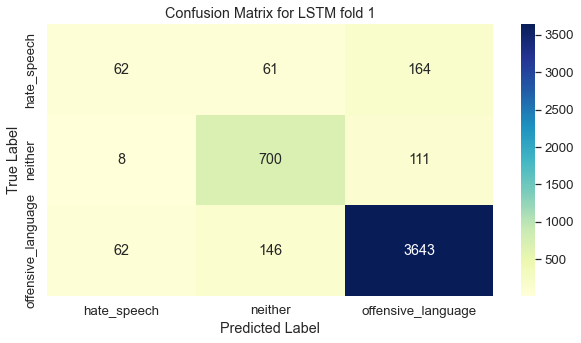

Classification Report:

                     precision    recall  f1-score   support

       hate_speech       0.47      0.22      0.30       287
           neither       0.77      0.85      0.81       819
offensive_language       0.93      0.95      0.94      3851

          accuracy                           0.89      4957
         macro avg       0.72      0.67      0.68      4957
      weighted avg       0.88      0.89      0.88      4957

----------------------------------------------------------------------------------------------------


C:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/10
496/496 [==============================] - 13s 23ms/step - loss: 0.4700 - accuracy: 0.8444 - val_loss: 0.2670 - val_accuracy: 0.9241 - lr: 1.0000e-04
Epoch 2/10
496/496 [==============================] - 11s 21ms/step - loss: 0.2609 - accuracy: 0.9178 - val_loss: 0.2287 - val_accuracy: 0.9185 - lr: 1.0000e-04
Epoch 3/10
496/496 [==============================] - 11s 22ms/step - loss: 0.2218 - accuracy: 0.9236 - val_loss: 0.2033 - val_accuracy: 0.9253 - lr: 1.0000e-04
Epoch 4/10
496/496 [==============================] - 11s 21ms/step - loss: 0.1905 - accuracy: 0.9340 - val_loss: 0.1910 - val_accuracy: 0.9306 - lr: 1.0000e-04
Epoch 5/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1634 - accuracy: 0.9453 - val_loss: 0.1996 - val_accuracy: 0.9279 - lr: 1.0000e-04
Epoch 6/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1463 - accuracy: 0.9491 - val_loss: 0.1993 - val_accuracy: 0.9291 - lr: 1.0000e-04
Epoch 7/10
155/155 [==============

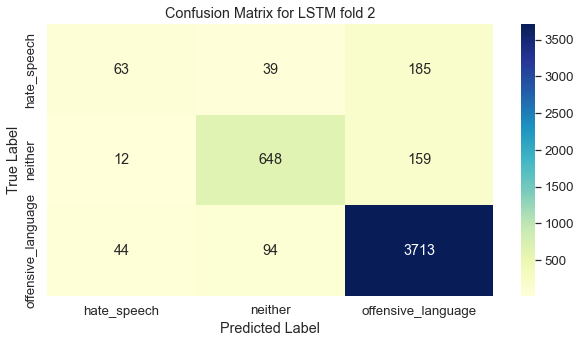

Classification Report:

                     precision    recall  f1-score   support

       hate_speech       0.53      0.22      0.31       287
           neither       0.83      0.79      0.81       819
offensive_language       0.92      0.96      0.94      3851

          accuracy                           0.89      4957
         macro avg       0.76      0.66      0.69      4957
      weighted avg       0.88      0.89      0.88      4957

----------------------------------------------------------------------------------------------------


C:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/10
496/496 [==============================] - 12s 21ms/step - loss: 0.4132 - accuracy: 0.8723 - val_loss: 0.2240 - val_accuracy: 0.9289 - lr: 1.0000e-04
Epoch 2/10
496/496 [==============================] - 10s 20ms/step - loss: 0.2137 - accuracy: 0.9275 - val_loss: 0.1787 - val_accuracy: 0.9359 - lr: 1.0000e-04
Epoch 3/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1723 - accuracy: 0.9407 - val_loss: 0.1498 - val_accuracy: 0.9488 - lr: 1.0000e-04
Epoch 4/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1458 - accuracy: 0.9494 - val_loss: 0.1430 - val_accuracy: 0.9485 - lr: 1.0000e-04
Epoch 5/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1318 - accuracy: 0.9532 - val_loss: 0.1444 - val_accuracy: 0.9470 - lr: 1.0000e-04
Epoch 6/10
155/155 [==============================] - 1s 5ms/step


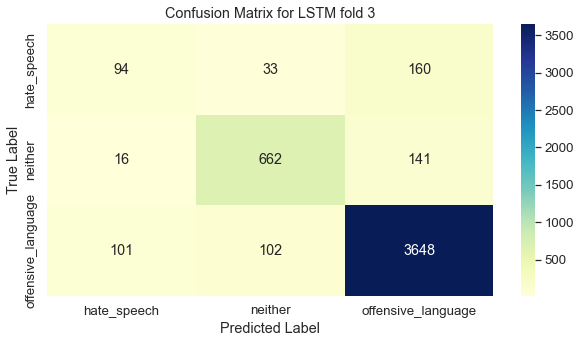

Classification Report:

                     precision    recall  f1-score   support

       hate_speech       0.45      0.33      0.38       287
           neither       0.83      0.81      0.82       819
offensive_language       0.92      0.95      0.94      3851

          accuracy                           0.89      4957
         macro avg       0.73      0.69      0.71      4957
      weighted avg       0.88      0.89      0.88      4957

----------------------------------------------------------------------------------------------------


C:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/10
496/496 [==============================] - 12s 21ms/step - loss: 0.3850 - accuracy: 0.8806 - val_loss: 0.2123 - val_accuracy: 0.9301 - lr: 1.0000e-04
Epoch 2/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1894 - accuracy: 0.9328 - val_loss: 0.1511 - val_accuracy: 0.9453 - lr: 1.0000e-04
Epoch 3/10
496/496 [==============================] - 10s 21ms/step - loss: 0.1440 - accuracy: 0.9514 - val_loss: 0.1568 - val_accuracy: 0.9453 - lr: 1.0000e-04
Epoch 4/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1258 - accuracy: 0.9550 - val_loss: 0.1298 - val_accuracy: 0.9549 - lr: 1.0000e-04
Epoch 5/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1135 - accuracy: 0.9600 - val_loss: 0.1330 - val_accuracy: 0.9538 - lr: 1.0000e-04
Epoch 6/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1033 - accuracy: 0.9630 - val_loss: 0.1380 - val_accuracy: 0.9538 - lr: 1.0000e-04
Epoch 7/10
155/155 [==============

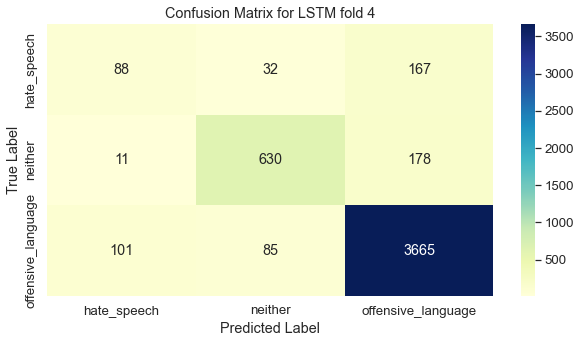

Classification Report:

                     precision    recall  f1-score   support

       hate_speech       0.44      0.31      0.36       287
           neither       0.84      0.77      0.80       819
offensive_language       0.91      0.95      0.93      3851

          accuracy                           0.88      4957
         macro avg       0.73      0.68      0.70      4957
      weighted avg       0.87      0.88      0.88      4957

----------------------------------------------------------------------------------------------------


C:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/10
496/496 [==============================] - 12s 21ms/step - loss: 0.4061 - accuracy: 0.8740 - val_loss: 0.2262 - val_accuracy: 0.9354 - lr: 1.0000e-04
Epoch 2/10
496/496 [==============================] - 10s 21ms/step - loss: 0.2011 - accuracy: 0.9316 - val_loss: 0.1562 - val_accuracy: 0.9442 - lr: 1.0000e-04
Epoch 3/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1496 - accuracy: 0.9462 - val_loss: 0.1279 - val_accuracy: 0.9559 - lr: 1.0000e-04
Epoch 4/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1241 - accuracy: 0.9560 - val_loss: 0.1170 - val_accuracy: 0.9581 - lr: 1.0000e-04
Epoch 5/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1129 - accuracy: 0.9611 - val_loss: 0.1178 - val_accuracy: 0.9569 - lr: 1.0000e-04
Epoch 6/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1010 - accuracy: 0.9651 - val_loss: 0.1144 - val_accuracy: 0.9576 - lr: 1.0000e-04
Epoch 7/10
496/496 [==============

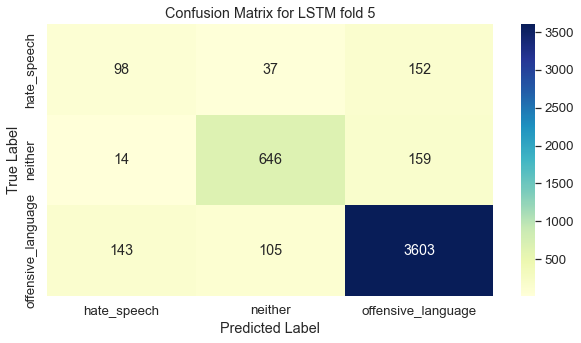

Classification Report:

                     precision    recall  f1-score   support

       hate_speech       0.38      0.34      0.36       287
           neither       0.82      0.79      0.80       819
offensive_language       0.92      0.94      0.93      3851

          accuracy                           0.88      4957
         macro avg       0.71      0.69      0.70      4957
      weighted avg       0.87      0.88      0.87      4957

----------------------------------------------------------------------------------------------------


In [54]:
history = {}
# K-Fold validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold_count = 1

LSTM_1 = None
LSTM_2 = None
LSTM_3 = None
LSTM_4 = None
LSTM_5 = None

# Define list to store test set performance for each fold
LSTM_test_scores = []

LSTM_list = [LSTM_1,LSTM_2,LSTM_3,LSTM_4,LSTM_5]

for train_index, val_index in kf.split(padded_X):
    le = LabelEncoder()
    X_train, X_val =padded_X[train_index],padded_X[val_index]
    y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]
    
    # label encoding for our categorical variable
    y_train = le.fit_transform(y_train)
    y_val = le.transform(y_val)
    y_test_encoded = le.transform(y_test)
    
    # One-hot encode the target variable
    y_train = to_categorical(y_train, num_classes)
    y_val = to_categorical(y_val, num_classes)
    y_test_encoded = to_categorical(y_test_encoded, num_classes)
    
    LSTM_list[fold_count-1] = model_LSTM()
    history["baseline_model_fold_"+str(fold_count)] = LSTM_list[fold_count-1].fit(X_train, y_train,
                batch_size=32,
                epochs=10,
                validation_data=(X_val, y_val),
                verbose=1,
                callbacks=callbacks)
    
    y_pred = LSTM_list[fold_count-1].predict(padded_x_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_pred_labels = le.inverse_transform(y_pred)
    
    y_test_labels = np.argmax(y_test_encoded, axis=1)
    y_test_labels = le.inverse_transform(y_test_labels)
    Confusion_Matrix( y_test_labels, y_pred_labels, np.unique(clean_twitter_data["class"]), fold_count, "LSTM")
    
    # Calculate precision, recall, and F1-score for each class
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_labels, y_pred_labels, average=None)

    # Append test set performance to list for this fold
    LSTM_test_scores.append((precision, recall, f1_score))
    fold_count+=1

## LSTM Model with undersampling

In [55]:
# Time to do some undersampling, we still retain the x_test as our unseen data 
# This is to ensure a fair comparison of different models

X_balanced = pd.DataFrame(X)
X_balanced

,clean_tweets
22347,still fuck old bitch disrespectful like shit
10712,love bitch talkin single life best life bitchi...
115,baseball season win yankee this love start
8137,both trash guess get tired chalmers trash star...
22845,why nude call nude would rather like hey girl ...
...,...
21575,the left though twitpic selfie bad bitch
5390,same like bitch struggle use stairs let people...
860,pornandroidiphoneipadsexxxx anal hardcore brit...
15795,yah hoe


In [56]:
under_sampled_data = pd.concat([X_balanced,Y], axis=1)
under_sampled_data

,clean_tweets,class
22347,still fuck old bitch disrespectful like shit,offensive_language
10712,love bitch talkin single life best life bitchi...,offensive_language
115,baseball season win yankee this love start,neither
8137,both trash guess get tired chalmers trash star...,offensive_language
22845,why nude call nude would rather like hey girl ...,offensive_language
...,...,...
21575,the left though twitpic selfie bad bitch,offensive_language
5390,same like bitch struggle use stairs let people...,offensive_language
860,pornandroidiphoneipadsexxxx anal hardcore brit...,offensive_language
15795,yah hoe,offensive_language


In [57]:
# Split the dataset into three subsets based on the class label
hate_class = under_sampled_data[under_sampled_data['class'] == "hate_speech"]
neither_class = under_sampled_data[under_sampled_data['class'] == "neither"]
offensive_class = under_sampled_data[under_sampled_data['class'] == "offensive_language"]

# Determine the size of the undersampled majority set
minority_size = min(len(hate_class), len(neither_class))
majority_size = minority_size 

In [58]:
# Make the dataset balanced 
undersampled_neither_class = neither_class.sample(majority_size, random_state=42)
undersampled_majority = offensive_class.sample(majority_size, random_state=42)

In [59]:
# Merge the undersampled majority set with the minority sets
balanced_df = pd.concat([undersampled_majority, undersampled_neither_class, hate_class], axis=0)

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42)
balanced_df

,clean_tweets,class
24192,love female hate bitch,offensive_language
5242,swear god log later i be post score every soci...,offensive_language
13377,no face trace pussy boy snatch,offensive_language
22086,this kid look like retard try hide phone obvious,hate_speech
6555,do not hurt little faggot,hate_speech
...,...,...
22601,what as mean get half cash man bitch kiss as,offensive_language
16379,bitch get chalk catch feeling,offensive_language
8433,charlie ron constantly put heat entire career,neither
17444,you be public side hoe,offensive_language


<AxesSubplot: xlabel='count', ylabel='class'>

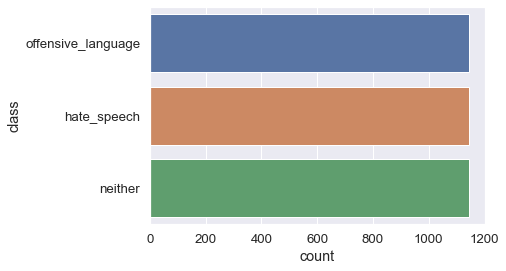

In [60]:
sb.countplot(y = "class", data = balanced_df)

In [61]:
X_balanced = balanced_df["clean_tweets"]
Y_balanced = balanced_df["class"]

In [62]:
padded_X_balanced = pad_sequences(tokenizer.texts_to_sequences(X_balanced), maxlen=max_len)

Epoch 1/10
86/86 [==============================] - 4s 32ms/step - loss: 0.9802 - accuracy: 0.6631 - val_loss: 0.8206 - val_accuracy: 0.7682 - lr: 1.0000e-04
Epoch 2/10
86/86 [==============================] - 2s 23ms/step - loss: 0.6536 - accuracy: 0.8024 - val_loss: 0.5347 - val_accuracy: 0.8630 - lr: 1.0000e-04
Epoch 3/10
86/86 [==============================] - 2s 23ms/step - loss: 0.4255 - accuracy: 0.8906 - val_loss: 0.3623 - val_accuracy: 0.8892 - lr: 1.0000e-04
Epoch 4/10
86/86 [==============================] - 2s 21ms/step - loss: 0.2917 - accuracy: 0.9256 - val_loss: 0.2890 - val_accuracy: 0.9125 - lr: 1.0000e-04
Epoch 5/10
86/86 [==============================] - 2s 20ms/step - loss: 0.2231 - accuracy: 0.9362 - val_loss: 0.2545 - val_accuracy: 0.9184 - lr: 1.0000e-04
Epoch 6/10
86/86 [==============================] - 2s 21ms/step - loss: 0.1929 - accuracy: 0.9398 - val_loss: 0.2294 - val_accuracy: 0.9169 - lr: 1.0000e-04
Epoch 7/10
86/86 [==============================] - 

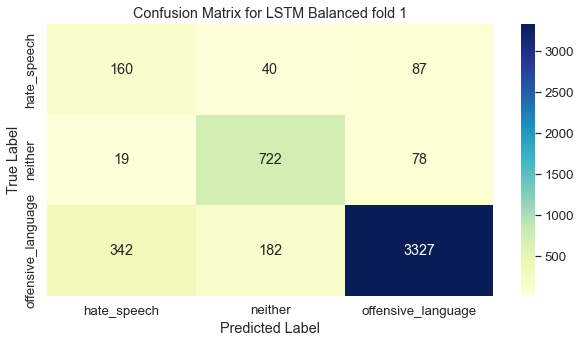

Classification Report:

                     precision    recall  f1-score   support

       hate_speech       0.31      0.56      0.40       287
           neither       0.76      0.88      0.82       819
offensive_language       0.95      0.86      0.91      3851

          accuracy                           0.85      4957
         macro avg       0.67      0.77      0.71      4957
      weighted avg       0.88      0.85      0.86      4957

----------------------------------------------------------------------------------------------------
Epoch 1/10
86/86 [==============================] - 4s 27ms/step - loss: 0.9844 - accuracy: 0.6806 - val_loss: 0.7949 - val_accuracy: 0.8907 - lr: 1.0000e-04
Epoch 2/10
86/86 [==============================] - 2s 23ms/step - loss: 0.6223 - accuracy: 0.8764 - val_loss: 0.4278 - val_accuracy: 0.9038 - lr: 1.0000e-04
Epoch 3/10
86/86 [==============================] - 2s 24ms/step - loss: 0.3599 - accuracy: 0.9198 - val_loss: 0.2697 - val_accuracy: 0

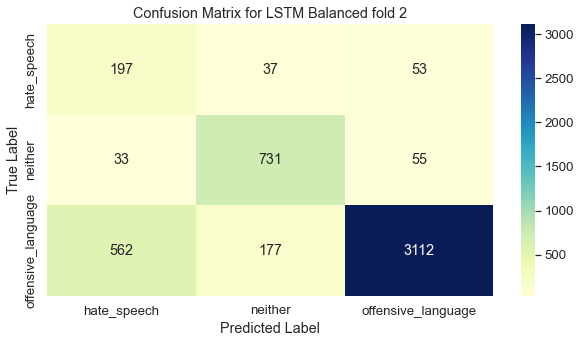

Classification Report:

                     precision    recall  f1-score   support

       hate_speech       0.25      0.69      0.37       287
           neither       0.77      0.89      0.83       819
offensive_language       0.97      0.81      0.88      3851

          accuracy                           0.82      4957
         macro avg       0.66      0.80      0.69      4957
      weighted avg       0.89      0.82      0.84      4957

----------------------------------------------------------------------------------------------------
Epoch 1/10
86/86 [==============================] - 4s 25ms/step - loss: 0.9405 - accuracy: 0.7641 - val_loss: 0.7224 - val_accuracy: 0.8324 - lr: 1.0000e-04
Epoch 2/10
86/86 [==============================] - 2s 22ms/step - loss: 0.5536 - accuracy: 0.8819 - val_loss: 0.4076 - val_accuracy: 0.9169 - lr: 1.0000e-04
Epoch 3/10
86/86 [==============================] - 2s 23ms/step - loss: 0.3323 - accuracy: 0.9245 - val_loss: 0.2343 - val_accuracy: 0

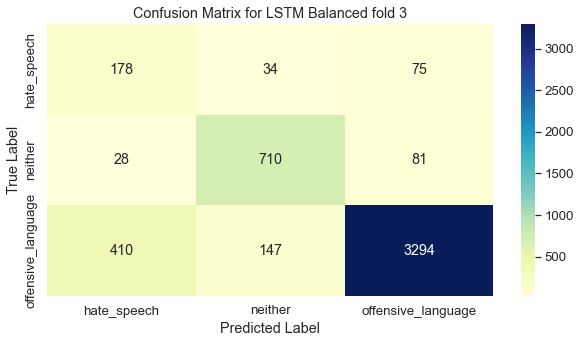

Classification Report:

                     precision    recall  f1-score   support

       hate_speech       0.29      0.62      0.39       287
           neither       0.80      0.87      0.83       819
offensive_language       0.95      0.86      0.90      3851

          accuracy                           0.84      4957
         macro avg       0.68      0.78      0.71      4957
      weighted avg       0.89      0.84      0.86      4957

----------------------------------------------------------------------------------------------------
Epoch 1/10
86/86 [==============================] - 4s 26ms/step - loss: 0.9254 - accuracy: 0.8206 - val_loss: 0.7035 - val_accuracy: 0.8644 - lr: 1.0000e-04
Epoch 2/10
86/86 [==============================] - 2s 20ms/step - loss: 0.5105 - accuracy: 0.8866 - val_loss: 0.3595 - val_accuracy: 0.9242 - lr: 1.0000e-04
Epoch 3/10
86/86 [==============================] - 2s 20ms/step - loss: 0.2815 - accuracy: 0.9435 - val_loss: 0.2275 - val_accuracy: 0

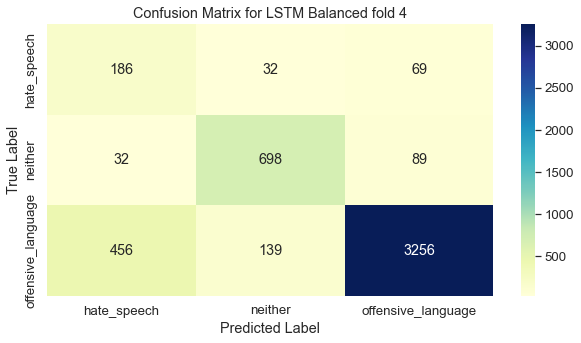

Classification Report:

                     precision    recall  f1-score   support

       hate_speech       0.28      0.65      0.39       287
           neither       0.80      0.85      0.83       819
offensive_language       0.95      0.85      0.90      3851

          accuracy                           0.84      4957
         macro avg       0.68      0.78      0.70      4957
      weighted avg       0.89      0.84      0.86      4957

----------------------------------------------------------------------------------------------------
Epoch 1/10
86/86 [==============================] - 4s 26ms/step - loss: 0.9037 - accuracy: 0.8134 - val_loss: 0.6520 - val_accuracy: 0.8876 - lr: 1.0000e-04
Epoch 2/10
86/86 [==============================] - 2s 23ms/step - loss: 0.4696 - accuracy: 0.9136 - val_loss: 0.2945 - val_accuracy: 0.9693 - lr: 1.0000e-04
Epoch 3/10
86/86 [==============================] - 2s 23ms/step - loss: 0.2696 - accuracy: 0.9410 - val_loss: 0.2133 - val_accuracy: 0

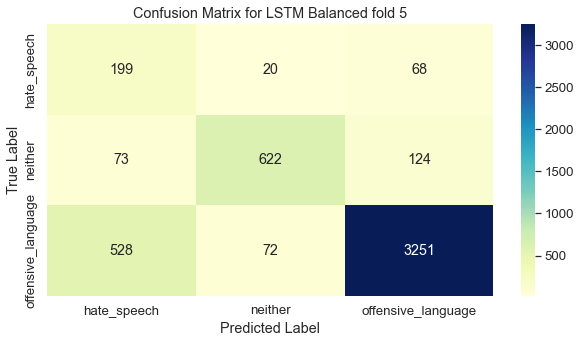

Classification Report:

                     precision    recall  f1-score   support

       hate_speech       0.25      0.69      0.37       287
           neither       0.87      0.76      0.81       819
offensive_language       0.94      0.84      0.89      3851

          accuracy                           0.82      4957
         macro avg       0.69      0.77      0.69      4957
      weighted avg       0.89      0.82      0.85      4957

----------------------------------------------------------------------------------------------------


In [63]:
history_balanced = {}
# K-Fold validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold_count = 1

LSTM_balanced_1 = None
LSTM_balanced_2 = None
LSTM_balanced_3 = None
LSTM_balanced_4 = None
LSTM_balanced_5 = None

# Define list to store test set performance for each fold
LSTM_balanced_test_scores = []

LSTM_balanced_list = [LSTM_balanced_1,LSTM_balanced_2,LSTM_balanced_3,LSTM_balanced_4,LSTM_balanced_5]

for train_index, val_index in kf.split(padded_X_balanced):
    le = LabelEncoder()
    X_train, X_val =padded_X_balanced[train_index],padded_X_balanced[val_index]
    y_train, y_val = Y_balanced.iloc[train_index], Y_balanced.iloc[val_index]
    
    # label encoding for our categorical variable
    y_train = le.fit_transform(y_train)
    y_val = le.transform(y_val)
    y_test_encoded = le.transform(y_test)
    
    # One-hot encode the target variable
    y_train = to_categorical(y_train, num_classes)
    y_val = to_categorical(y_val, num_classes)
    y_test_encoded = to_categorical(y_test_encoded, num_classes)
    
    LSTM_balanced_list[fold_count-1] = model_LSTM()
    history_balanced["balanced_model_fold_"+str(fold_count)] = LSTM_balanced_list[fold_count-1].fit(X_train, y_train,
                batch_size=32,
                epochs=10,
                validation_data=(X_val, y_val),
                verbose=1,
                callbacks=callbacks)
    
    y_pred = LSTM_balanced_list[fold_count-1].predict(padded_x_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_pred_labels = le.inverse_transform(y_pred)
    
    y_test_labels = np.argmax(y_test_encoded, axis=1)
    y_test_labels = le.inverse_transform(y_test_labels)
    Confusion_Matrix( y_test_labels, y_pred_labels, np.unique(clean_twitter_data["class"]), fold_count, "LSTM Balanced")
    
    # Calculate precision, recall, and F1-score for each class
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_labels, y_pred_labels, average=None)

    # Append test set performance to list for this fold
    LSTM_balanced_test_scores.append((precision, recall, f1_score))
    
    fold_count+=1

## LSTM Model with class_weights

In [64]:
from sklearn.utils import class_weight
import pandas as pd

In [65]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes = np.unique(Y["class"]),
                                                  y = Y["class"])
print(class_weights)

[5.78127734 1.97666766 0.4308254 ]


C:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/10
496/496 [==============================] - 13s 23ms/step - loss: 0.4896 - accuracy: 0.8992 - val_loss: 0.3073 - val_accuracy: 0.8933 - lr: 1.0000e-04
Epoch 2/10
496/496 [==============================] - 11s 22ms/step - loss: 0.2253 - accuracy: 0.9008 - val_loss: 0.2349 - val_accuracy: 0.9153 - lr: 1.0000e-04
Epoch 3/10
496/496 [==============================] - 10s 21ms/step - loss: 0.1964 - accuracy: 0.9112 - val_loss: 0.1857 - val_accuracy: 0.9319 - lr: 1.0000e-04
Epoch 4/10
496/496 [==============================] - 10s 21ms/step - loss: 0.1706 - accuracy: 0.9209 - val_loss: 0.2314 - val_accuracy: 0.9122 - lr: 1.0000e-04
Epoch 5/10
496/496 [==============================] - 10s 21ms/step - loss: 0.1521 - accuracy: 0.9305 - val_loss: 0.1921 - val_accuracy: 0.9264 - lr: 1.0000e-04
Epoch 6/10
155/155 [==============================] - 1s 6ms/step


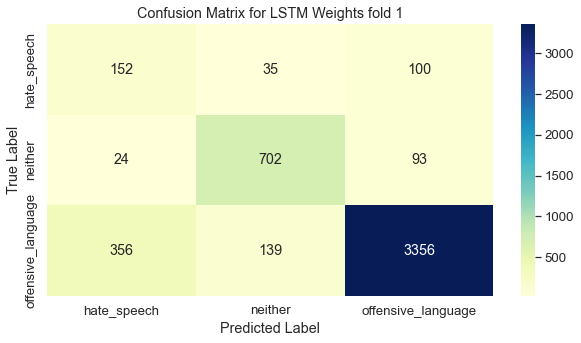

Classification Report:

                     precision    recall  f1-score   support

       hate_speech       0.29      0.53      0.37       287
           neither       0.80      0.86      0.83       819
offensive_language       0.95      0.87      0.91      3851

          accuracy                           0.85      4957
         macro avg       0.68      0.75      0.70      4957
      weighted avg       0.88      0.85      0.86      4957

----------------------------------------------------------------------------------------------------


C:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/10
496/496 [==============================] - 13s 23ms/step - loss: 0.4702 - accuracy: 0.9079 - val_loss: 0.2492 - val_accuracy: 0.9261 - lr: 1.0000e-04
Epoch 2/10
496/496 [==============================] - 11s 22ms/step - loss: 0.2226 - accuracy: 0.9093 - val_loss: 0.2557 - val_accuracy: 0.9137 - lr: 1.0000e-04
Epoch 3/10
496/496 [==============================] - 11s 21ms/step - loss: 0.1877 - accuracy: 0.9199 - val_loss: 0.2622 - val_accuracy: 0.9049 - lr: 1.0000e-04
Epoch 4/10
155/155 [==============================] - 2s 6ms/step


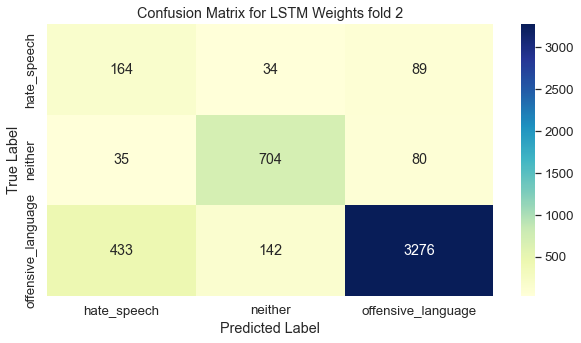

Classification Report:

                     precision    recall  f1-score   support

       hate_speech       0.26      0.57      0.36       287
           neither       0.80      0.86      0.83       819
offensive_language       0.95      0.85      0.90      3851

          accuracy                           0.84      4957
         macro avg       0.67      0.76      0.69      4957
      weighted avg       0.89      0.84      0.86      4957

----------------------------------------------------------------------------------------------------


C:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/10
496/496 [==============================] - 12s 21ms/step - loss: 0.4542 - accuracy: 0.9058 - val_loss: 0.1833 - val_accuracy: 0.9412 - lr: 1.0000e-04
Epoch 2/10
496/496 [==============================] - 10s 20ms/step - loss: 0.2009 - accuracy: 0.9122 - val_loss: 0.1848 - val_accuracy: 0.9349 - lr: 1.0000e-04
Epoch 3/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1766 - accuracy: 0.9190 - val_loss: 0.1820 - val_accuracy: 0.9344 - lr: 1.0000e-04
Epoch 4/10
496/496 [==============================] - 10s 21ms/step - loss: 0.1554 - accuracy: 0.9286 - val_loss: 0.1223 - val_accuracy: 0.9576 - lr: 1.0000e-04
Epoch 5/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1462 - accuracy: 0.9325 - val_loss: 0.1999 - val_accuracy: 0.9264 - lr: 1.0000e-04
Epoch 6/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1352 - accuracy: 0.9368 - val_loss: 0.2492 - val_accuracy: 0.9037 - lr: 1.0000e-04
Epoch 7/10
155/155 [==============

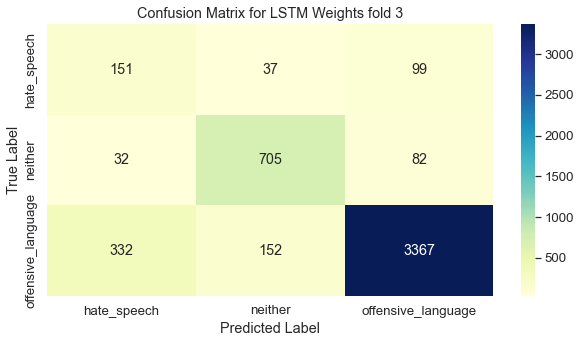

Classification Report:

                     precision    recall  f1-score   support

       hate_speech       0.29      0.53      0.38       287
           neither       0.79      0.86      0.82       819
offensive_language       0.95      0.87      0.91      3851

          accuracy                           0.85      4957
         macro avg       0.68      0.75      0.70      4957
      weighted avg       0.88      0.85      0.86      4957

----------------------------------------------------------------------------------------------------


C:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/10
496/496 [==============================] - 12s 21ms/step - loss: 0.4544 - accuracy: 0.9140 - val_loss: 0.3246 - val_accuracy: 0.8840 - lr: 1.0000e-04
Epoch 2/10
496/496 [==============================] - 10s 21ms/step - loss: 0.1873 - accuracy: 0.9211 - val_loss: 0.1476 - val_accuracy: 0.9470 - lr: 1.0000e-04
Epoch 3/10
496/496 [==============================] - 10s 21ms/step - loss: 0.1587 - accuracy: 0.9294 - val_loss: 0.1741 - val_accuracy: 0.9357 - lr: 1.0000e-04
Epoch 4/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1486 - accuracy: 0.9322 - val_loss: 0.2411 - val_accuracy: 0.9079 - lr: 1.0000e-04
Epoch 5/10
155/155 [==============================] - 1s 6ms/step


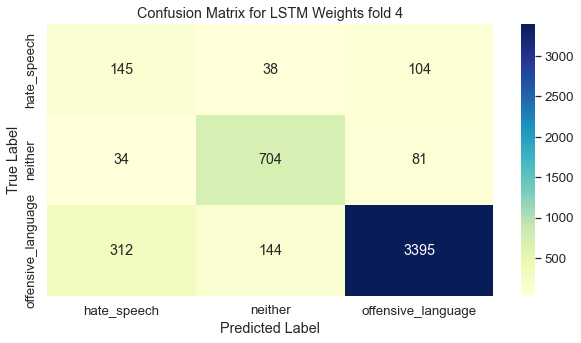

Classification Report:

                     precision    recall  f1-score   support

       hate_speech       0.30      0.51      0.37       287
           neither       0.79      0.86      0.83       819
offensive_language       0.95      0.88      0.91      3851

          accuracy                           0.86      4957
         macro avg       0.68      0.75      0.70      4957
      weighted avg       0.89      0.86      0.87      4957

----------------------------------------------------------------------------------------------------


C:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/10
496/496 [==============================] - 12s 21ms/step - loss: 0.4565 - accuracy: 0.9098 - val_loss: 0.2818 - val_accuracy: 0.9004 - lr: 1.0000e-04
Epoch 2/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1915 - accuracy: 0.9211 - val_loss: 0.1857 - val_accuracy: 0.9319 - lr: 1.0000e-04
Epoch 3/10
496/496 [==============================] - 10s 21ms/step - loss: 0.1608 - accuracy: 0.9298 - val_loss: 0.1748 - val_accuracy: 0.9334 - lr: 1.0000e-04
Epoch 4/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1396 - accuracy: 0.9353 - val_loss: 0.1852 - val_accuracy: 0.9291 - lr: 1.0000e-04
Epoch 5/10
496/496 [==============================] - 10s 20ms/step - loss: 0.1345 - accuracy: 0.9372 - val_loss: 0.1421 - val_accuracy: 0.9415 - lr: 1.0000e-04
Epoch 6/10
496/496 [==============================] - 10s 21ms/step - loss: 0.1234 - accuracy: 0.9436 - val_loss: 0.1847 - val_accuracy: 0.9306 - lr: 1.0000e-04
Epoch 7/10
496/496 [==============

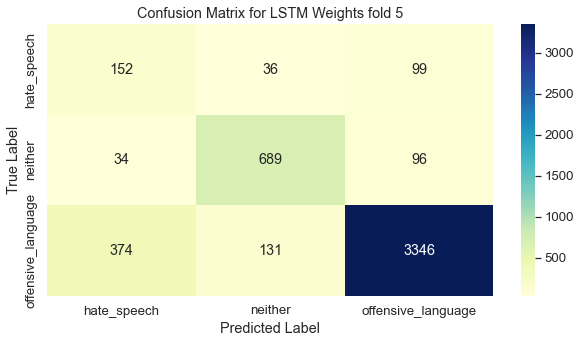

Classification Report:

                     precision    recall  f1-score   support

       hate_speech       0.27      0.53      0.36       287
           neither       0.80      0.84      0.82       819
offensive_language       0.94      0.87      0.91      3851

          accuracy                           0.84      4957
         macro avg       0.67      0.75      0.70      4957
      weighted avg       0.88      0.84      0.86      4957

----------------------------------------------------------------------------------------------------


In [66]:
history_class_weights = {}
# K-Fold validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold_count = 1

LSTM_weights_1 = None
LSTM_weights_2 = None
LSTM_weights_3 = None
LSTM_weights_4 = None
LSTM_weights_5 = None

# Define list to store test set performance for each fold
LSTM_weights_test_scores = []

LSTM_weights_list = [LSTM_weights_1,LSTM_weights_2,LSTM_weights_3,LSTM_weights_4,LSTM_weights_5]

for train_index, val_index in kf.split(padded_X):
    le = LabelEncoder()
    X_train, X_val =padded_X[train_index],padded_X[val_index]
    y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]
    
    # Calculate class weights
    class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes = np.unique(y_train["class"]),
                                                  y = y_train["class"])
    class_weights = dict(enumerate(class_weights))
    
    # label encoding for our categorical variable
    y_train = le.fit_transform(y_train)
    y_val = le.transform(y_val)
    y_test_encoded = le.transform(y_test)
    
    # One-hot encode the target variable
    y_train = to_categorical(y_train, num_classes)
    y_val = to_categorical(y_val, num_classes)
    y_test_encoded = to_categorical(y_test_encoded, num_classes)
    
    LSTM_weights_list[fold_count-1] = model_LSTM()
    history_class_weights["weights_model_fold_"+str(fold_count)] = LSTM_weights_list[fold_count-1].fit(X_train, y_train,
                batch_size=32,
                epochs=10,
                validation_data=(X_val, y_val),
                verbose=1,
                callbacks=callbacks, class_weight=class_weights)
    
    y_pred = LSTM_weights_list[fold_count-1].predict(padded_x_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_pred_labels = le.inverse_transform(y_pred)
    
    y_test_labels = np.argmax(y_test_encoded, axis=1)
    y_test_labels = le.inverse_transform(y_test_labels)
    
    Confusion_Matrix(y_test_labels, y_pred_labels, np.unique(clean_twitter_data["class"]), fold_count, "LSTM Weights")
    
    # Calculate precision, recall, and F1-score for each class
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_labels, y_pred_labels, average=None)

    # Append test set performance to list for this fold
    LSTM_weights_test_scores.append((precision, recall, f1_score))
    
    fold_count+=1

# Model Comparison

In [67]:
LSTM_mean_test_scores = np.mean(LSTM_test_scores, axis=0)
LSTM_balanced_mean_test_scores = np.mean(LSTM_balanced_test_scores, axis=0)
LSTM_weights_mean_test_scores =  np.mean(LSTM_weights_test_scores, axis=0)

In [68]:
print(LSTM_mean_test_scores)

[[0.45378402 0.81905317 0.92066086]
 [0.28222997 0.802442   0.94894833]
 [0.3413635  0.80980224 0.93454503]]


In [69]:
print(LSTM_balanced_mean_test_scores)

[[0.27390291 0.8019207  0.95438921]
 [0.64111498 0.85054945 0.84341729]
 [0.38173521 0.82335219 0.89529925]]


In [70]:
print(LSTM_weights_mean_test_scores)

[[0.28103122 0.79788988 0.94776041]
 [0.53240418 0.85567766 0.86938458]
 [0.36726342 0.82573034 0.90684382]]


In [71]:
precision = np.array([LSTM_mean_test_scores[0],LSTM_balanced_mean_test_scores[0],LSTM_weights_mean_test_scores[0]])
recall = np.array([LSTM_mean_test_scores[1],LSTM_balanced_mean_test_scores[1],LSTM_weights_mean_test_scores[1]])
f1_score = np.array([LSTM_mean_test_scores[2],LSTM_balanced_mean_test_scores[2],LSTM_weights_mean_test_scores[2]])

In [81]:
print(precision)

[[0.45378402 0.81905317 0.92066086]
 [0.27390291 0.8019207  0.95438921]
 [0.28103122 0.79788988 0.94776041]]


In [133]:

def plot_bar(legend, y, label, title):
    plt.figure(figsize=(20,20))
    x = np.arange(len(y[0]))  # x-coordinates of bars
    bar_width = 0.1  # width of each bar

    # plot each sublist of data as a group of bars with the same color
    for i, sublist in enumerate(y):
        plt.bar(x + i*bar_width, sublist, bar_width, label=label[i])

    plt.xticks(x + bar_width, legend, fontsize=20)
    plt.ylabel(title+" score", fontsize=20)
    plt.title(title, fontsize=20)
    plt.legend()
    plt.savefig("visualizations/evaluation_plot for "+title+".jpg")
    plt.show()

In [134]:
legend = ['LSTM', 'LSTM_balanced', 'LSTM_weights']  # Legends
classes = ["Hate Speech", "Neither", "Offensive Language"]

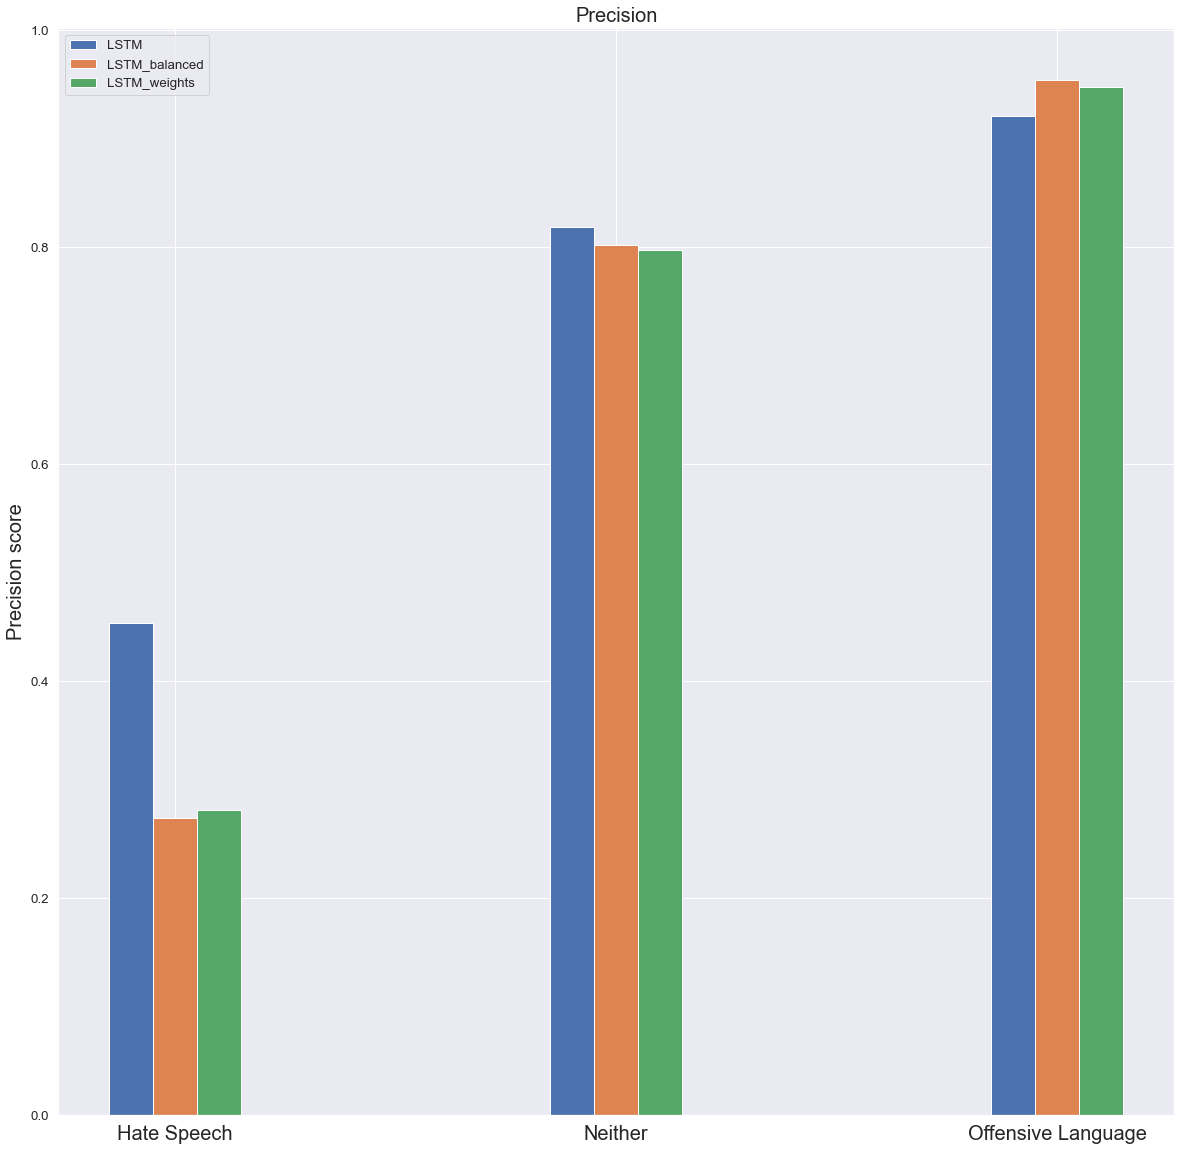

In [135]:
plot_bar(classes, precision, legend,"Precision")

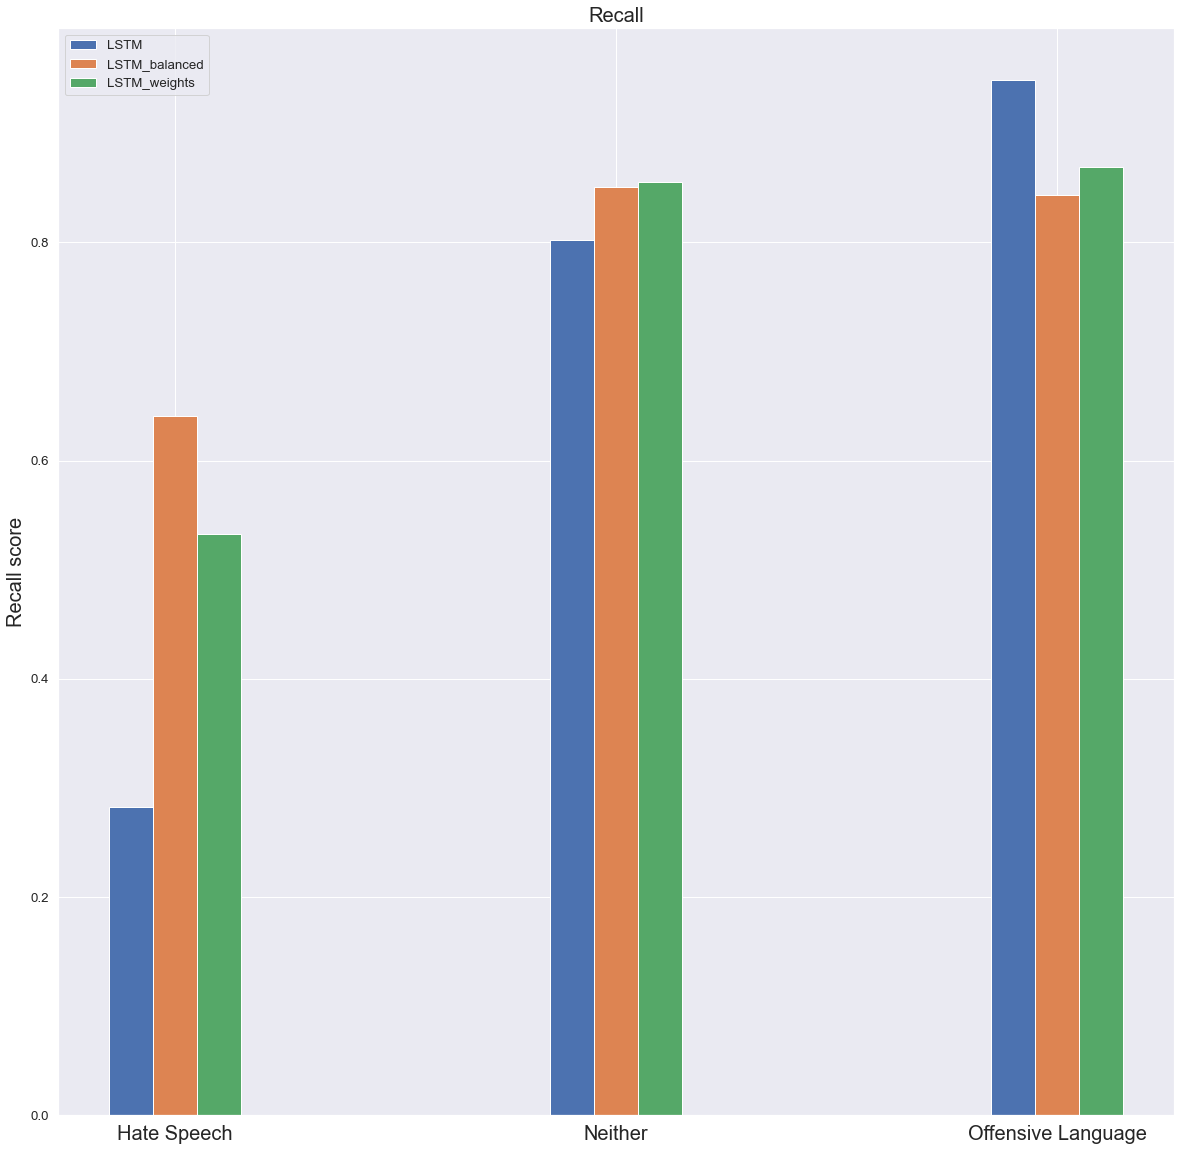

In [136]:
plot_bar(classes, recall, legend,"Recall")

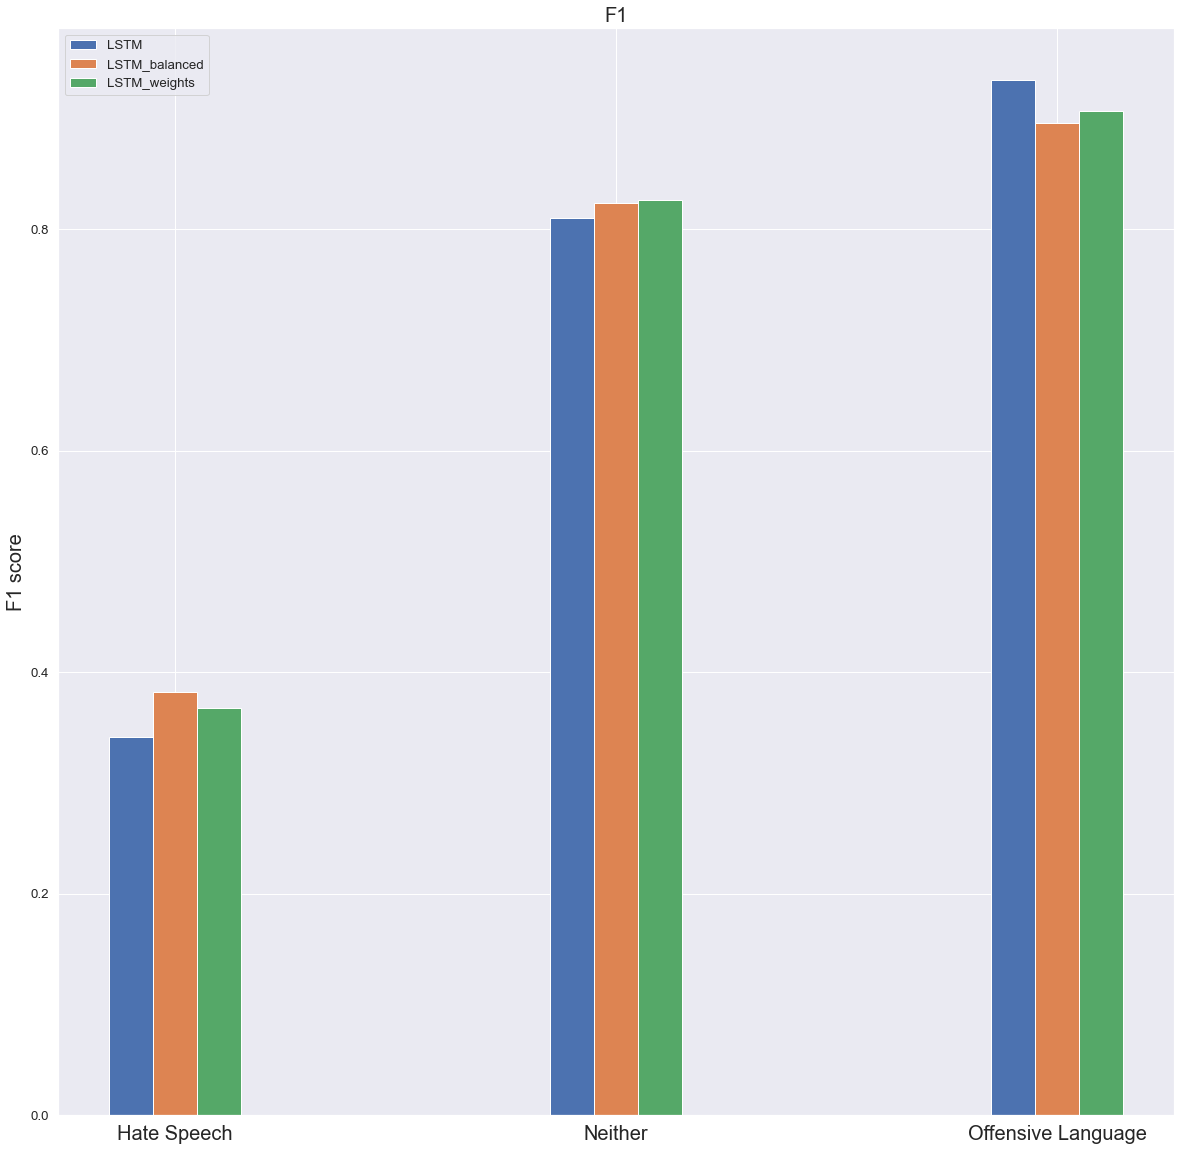

In [139]:
plot_bar(classes, f1_score, legend,"F1")